# IMPORTS

In [8]:
#importing relevant libraries

import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit    #for fitting an exponential
from scipy.fft import fft, fftfreq, rfft, rfftfreq
import functools as fnt
from textwrap import wrap
import matplotlib.collections as mcoll
import matplotlib.path as mpath
import emd
from scipy.signal import find_peaks
from scipy.signal import welch
import sys
from matplotlib.lines import Line2D

# CONSTANTS

In [9]:
#relevant constants
pc = 3.086e18                   #cm
pi = np.pi
s_to_yr = 3.171e-8               #seconds to years
#galaxy specific constants (taken from SS21_ch11)
R = 10*(10**3)*pc           #radius in cm
# omega = 6.481*(10**(-18))   #angular velocity in s^-1
h = 0.5*(10**3)*pc          #height in cm
eta_T = 10**26              #Diffusion coefficient in cm^2 s^-1
to = h*h/eta_T              #diffusion time in s
to_gyr = round(to*s_to_yr*1e-9, 3)    #diffusion time in Gyr
print("Diffusion timescale to = ", to_gyr, 'Gyr')
print('time stepping is normalised to t_o(s) = ', to, 's')

Diffusion timescale to =  0.755 Gyr
time stepping is normalised to t_o(s) =  2.380849e+16 s


# DIFFERENTIAL EQUATIONS

##### changes made to the differential equations for task 3 :
- made alpha independent of $r$ and dependent on $z$
- instead of passing $R_\alpha$ and $D$ like in task 2, the $B_\phi$ differential equation now depends on $R_\alpha$ and $R_\omega$, and $D$ is calculated as $R_\alpha R_\omega$

In [10]:
def Br_diff(t, Br, Bp, r_ind, dz, alpha):                          #for both alpha-omega and alpha-square omega dynamo

    dBr_dt = np.array(-1*(-3*alpha[0]*Bp[0] + 4*alpha[1]*Bp[1] - alpha[2]*Bp[2])/(2*dz) + (2*Br[0] - 5*Br[1] + 4*Br[2] - Br[3])/(dz**2))                           #for boundary
    dBr_dt = np.append(dBr_dt, -1*np.array(alpha[2:]*Bp[2:] - alpha[:-2]*Bp[:-2])/(2*dz) + np.array(Br[:-2] + Br[2:] - 2*Br[1:-1])/(dz**2))                        #for interior
    dBr_dt = np.append(dBr_dt, -1*(3*alpha[-1]*Bp[-1] - 4*alpha[-2]*Bp[-2] + alpha[-3]*Bp[-3])/(2*dz) + (2*Br[-1] - 5*Br[-2] + 4*Br[-3] - Br[-4])/(dz**2))         #for boundary
    return dBr_dt

def Bp_diff(t, Br, Bp, r_ind, dz, alpha, S, Ralpha, Romega, ao = True):     
    D = Ralpha*Romega
    if ao:          #for alpha-omega dynamo 
        dBp_dt = np.array( D*S[r_ind]*Br[0] + (2*Bp[0] - 5*Bp[1] + 4*Bp[2] - Bp[3])/(dz**2) )                                               #for boundary
        dBp_dt = np.append(dBp_dt, D*S[r_ind]*np.array(Br[1:-1]) + np.array(Bp[:-2] + Bp[2:] - 2*Bp[1:-1])/(dz**2))                         #for interior
        dBp_dt = np.append(dBp_dt, D*S[r_ind]*Br[-1] + (2*Bp[-1] - 5*Bp[-2] + 4*Bp[-3] - Bp[-4])/(dz**2))                                   #for boundary
    else:           #for alpha-square omega dynamo
        dBp_dt = np.array( D*S[r_ind]*Br[0] + (Ralpha**2)*(-3*alpha[0]*Br[0] + 4*alpha[1]*Br[1] - alpha[2]*Br[2])/(2*dz) + (2*Bp[0] - 5*Bp[1] + 4*Bp[2] - Bp[3])/(dz**2))                         #for boundary
        dBp_dt = np.append(dBp_dt, D*S[r_ind]*np.array(Br[1:-1]) + (Ralpha**2)*np.array(alpha[2:]*Br[2:] - alpha[:-2]*Br[:-2])/(2*dz) + np.array(Bp[:-2] + Bp[2:] - 2*Bp[1:-1])/(dz**2))          #for interior
        dBp_dt = np.append(dBp_dt, D*S[r_ind]*Br[-1] + (Ralpha**2)*(3*alpha[-1]*Br[-1] - 4*alpha[-2]*Br[-2] + alpha[-3]*Br[-3])/(2*dz) + (2*Bp[-1] - 5*Bp[-2] + 4*Bp[-3] - Bp[-4])/(dz**2))       #for boundary
    return dBp_dt

def rk4(F, G, X, Y, BX0, BXn, BY0, BYn, t, dt, dz, bc = 'dir'):
    #F is the function for the time evolution of X, in our case Br
    #G is the function for the time evolution of Y, in our case Bp
    #X is the array of X values
    #Y is the array of Y values
    #t is the current time
    #dt is the time step
    #dz is the spatial step
    #bc is the boundary condition type
    #BX0, BY0, BXn, BYn are the boundary values

    #We know the time evolution of the borders
    #So we only need to solve for the interior

    #let len(X) = len(Y) = n
    #Assigning the first boundary value
    if bc == 'dir':
        X_new = np.array([BX0])
        Y_new = np.array([BY0])
    elif bc == 'neu':
        X_new = np.array([4*X[1]/3 - X[2]/3 - 2*dz*BX0/3])
        Y_new = np.array([4*Y[1]/3 - Y[2]/3 - 2*dz*BY0/3])

    #Solving the runge kutta coefficients
    k1 = F(t, X, Y)                                     #len = n
    l1 = G(t, X, Y)                                     #len = n

    k2 = F(t + dt/2, X + k1*dt/2, Y + l1*dt/2)          #len = n        
    l2 = G(t + dt/2, X + k1*dt/2, Y + l1*dt/2)          #len = n

    k3 = F(t + dt/2, X + k2*dt/2, Y + l2*dt/2)          #len = n
    l3 = G(t + dt/2, X + k2*dt/2, Y + l2*dt/2)          #len = n

    k4 = F(t + dt, X + k3*dt, Y + l3*dt)                #len = n
    l4 = G(t + dt, X + k3*dt, Y + l3*dt)                #len = n

    #Assigning the interior values
    X_new = np.append(X_new, X[1:-1] + np.array(k1 + 2*k2 + 2*k3 + k4)[1:-1]*dt/6)
    Y_new = np.append(Y_new, Y[1:-1] + np.array(l1 + 2*l2 + 2*l3 + l4)[1:-1]*dt/6)

    #Assigning the last boundary value
    if bc == 'dir':
        X_new = np.append(X_new, BXn)        
        Y_new = np.append(Y_new, BYn)
    elif bc == 'neu':
        X_new = np.append(X_new, 4*X[-2]/3 - X[-3]/3 + 2*dz*BXn/3)
        Y_new = np.append(Y_new, 4*Y[-2]/3 - Y[-3]/3 + 2*dz*BYn/3)

    return X_new, Y_new

def plot_magnetic_fields(z, B_sol, D, steps):

    fig, axs = plt.subplots(3, 1, figsize = (7, 21))
    i = 100

    axs[0].plot(z, B_sol[0][0][0], color = 'red')
    axs[1].plot(z, B_sol[1][0][0], color = 'red')
    axs[2].plot(z, np.sqrt((B_sol[0][0][0])**2 + (B_sol[1][0][0])**2), color = 'red')

    while i < steps:

        axs[0].plot(z, B_sol[0][0][i], color = (round(i/(2*steps), 5), 0.1, 0.5, round(1-i/(1.5*steps), 5)))
        axs[1].plot(z, B_sol[1][0][i], color = (round(i/(2*steps), 5), 0.1, 0.5, round(1-i/(1.5*steps), 5)))
        axs[2].plot(z, np.sqrt((B_sol[0][0][i])**2 + (B_sol[1][0][i])**2), color = (round(i/(2*steps), 5), 0.1, 0.5, round(1-i/(1.5*steps), 5)))
        i += 100
    
    axs[0].set_title(r'$B_r$ for $D = $'+str(D))
    axs[0].set(xlabel='z/h', ylabel=r'$B_r/B_0$', fontsize=14)
    axs[0].tick_params(axis='x', labelsize=14)
    axs[0].tick_params(axis='y', labelsize=14)
    axs[1].set_title(r'$B_\phi$ for $D = $'+str(D))
    axs[1].set(xlabel='z/h', ylabel=r'$B_p/B_0$', fontsize=14)
    axs[1].tick_params(axis='x', labelsize=14)
    axs[1].tick_params(axis='y', labelsize=14) 
    axs[2].set_title(r'$B_{tot}$ for $D = $'+str(D))
    axs[2].set(xlabel='z/h', ylabel=r'$B_{tot}/B_0$', fontsize=14)
    axs[2].tick_params(axis='x', labelsize=14)
    axs[2].tick_params(axis='y', labelsize=14)
    plt.show()
    plt.close()

def plot_final_magnetic_fields(z, B_sol, D):
    fig, axs = plt.subplots(1, figsize = (10, 8))

    axs.plot(z, B_sol[0][0][-1], color = 'blue', label = r'$B_r$')
    axs.plot(z, B_sol[1][0][-1], color = 'green', label = r'$B_{\phi}$')
    axs.plot(z, np.sqrt((B_sol[0][0][-1])**2 + (B_sol[1][0][-1])**2), color = 'red', label = r'$B_{tot}$')
    
    axs.set_title(r'Final Eigen Modes for $D = $'+str(D), fontsize = 16)
    axs.tick_params(axis='x', labelsize=14)
    axs.tick_params(axis='y', labelsize=14)
    axs.set_xlabel(r'$z/h$', fontsize=14) 
    axs.set_ylabel(r'$B/B_0$', fontsize=14)
    axs.legend(fontsize=14)
    plt.show()
    plt.close()

def plot_growth(z, t, B_sol, D, log = False):
    z1 = len(z)//2
    dz = (len(z)//2)//4
    z2 = z1 + dz
    z3 = z1 + 2*dz
    z4 = z1 + 3*dz

    B_total = np.sqrt(B_sol[0][0]**2 + B_sol[1][0]**2)

    B_total1 = B_total[:,z1]
    B_total2 = B_total[:,z2]
    B_total3 = B_total[:,z3]
    B_total4 = B_total[:,z4]

    fig, axs = plt.subplots(1, figsize = (12, 8))

    axs.plot(t, B_total1, color = 'blue', label = r'$z/h =$ '+str(round(z[z1], 3)))
    axs.plot(t, B_total2, color = 'green', label = r'$z/h =$ '+str(round(z[z2], 3)))
    axs.plot(t, B_total3, color = 'red', label = r'$z/h =$ '+str(round(z[z3], 3)))
    axs.plot(t, B_total4, color = 'purple', label = r'$z/h =$ '+str(round(z[z4], 3)))

    axs.set_title(r'Growth of $B_{tot}$ for $D = $'+str(D), fontsize = 16)
    axs.set_xlim(0, t[-1])
    axs.tick_params(axis='x', labelsize=14)
    axs.tick_params(axis='y', labelsize=14)
    axs.set_xlabel(r'$t/t_0$', fontsize=14)
    axs.set_ylabel(r'$B_{tot}/B_0$', fontsize=14)
    if log:
        axs.set_yscale('log')
    axs.legend(fontsize=14)
    
    plt.show()
    plt.close()

def find_local_gamma(z, t, t_ini, B_total):#, tol = 0.1):
    t0_index = np.where(t>t_ini)[0][0]
    gamma = (np.log10(B_total)[-1,:] - np.log10(B_total)[t0_index,:])/(t[-1] - t[t0_index])
    # gamma = (np.log10(B_total)[-1,:] - np.log10(B_total)[0,:])/(t[-1] - t[0])
    # for i in range(len(z)):
    #     j = 1
    #     temp = (np.log10(B_total)[-1,i] - np.log10(B_total)[j,i])/(t[-1] - t[j])
    #     while abs(gamma[i] - temp) > tol:
    #         gamma[i] = (np.log10(B_total)[-1,i] - np.log10(B_total)[j,i])/(t[-1] - t[j])
    #         temp = (np.log10(B_total)[-1,i] - np.log10(B_total)[j+1,i])/(t[-1] - t[j+1])
    #         j += 1
    return gamma

def find_pitch_angle(z, B_sol):
    pitch_angle = np.arctan(B_sol[0][0]/B_sol[1][0])
    return pitch_angle

def gamma_noz(D, D_c):
    return (np.sqrt(-D) - np.sqrt(-D_c))

def linear(t, gamma, b):
    return gamma*t + b

def fit_linear(data, t):
    popt, pcov = curve_fit(linear, t, data, maxfev = 10000)
    return popt, pcov


# RUNGE KUTTA (4TH ORDER)

### For Dirichlet Boundary Conditions
These boundary conditions specify that the time evolution of the boundary values is fixed to some number.

### For Neumann Boundary Conditions
These boundary conditions specify that the spatial derivatives of the function values are some number at the boundary.

This Runge-Kutta code solves a general system of differential equations in two variables(since in our case we have Br and Bphi)

In [12]:
#defining the grid and timestepping

#grid parameters
z_res = 5*10**1                 #resolution
r_res = 10**1                   #resolution
z0 = -1                         #lower z/h limit
zn = 1                          #upper z/h limit
r0 = 0.001                      #lower r/R limit
rn = 1                          #upper r/R limit
dz = (zn-z0)/z_res              #step size
dr = (rn-r0)/r_res              #step size
z = np.linspace(z0, zn, z_res)  #normalised to scale height h
r = np.linspace(r0, rn, r_res)  #normalised to radius R

#time parameters
dt = 0.00079
t0 = 0

print('dt/to =', dt, 'and dz =', dz, 'in dimensionless coordinates')
print('The solution is stable when 2*dt/(dz**2) =', 2*dt/(dz**2), '< 1')

print('dt =', dt*to*s_to_yr*1e-9, 'Gyr')
print('No. of timesteps needed for 2 Gyr =', 2/(dt*to*s_to_yr*1e-9))

dt/to = 0.00079 and dz = 0.04 in dimensionless coordinates
The solution is stable when 2*dt/(dz**2) = 0.9874999999999999 < 1
dt = 0.000596424102141 Gyr
No. of timesteps needed for 2 Gyr = 3353.3185409854245


In [13]:
#constants and other known variables (0 for the diffusion equation)
l0 = 0.1*(10**2)*pc                     #in cm
V0 = 2*10**7                            #in cm/s
omega0 = 100*(100)/pc                   #in s^-1, omega0 = 100 km s^-1 kpc^-1
alpha0 = (l0**2)*omega0/h               #normalised to l0**2 omega0/h
S0 = -omega0/2                          #normalised to 1/r
r_omega = 2*(10**3)*pc/R                #2kpc/R
print(alpha0)
alpha = np.sin(pi*z)                                                        #normalised to alpha0
omega = np.sqrt(2/(1+(r**2)/(r_omega**2)))                                  #normalised to omega0
S = 2*np.sqrt(2)*(r**2/r_omega**2)*np.power(1+(r**2)/(r_omega**2), -3/2)    #normalised to S0 = -omega0/2
Romega = -1*np.linspace(0, 20, 41)
Ralpha = np.linspace(0, 20, 41)                              
r_ind = np.where(r >= 0.4)[0][0]        #Pick r where r/R around 0.4

#Initial seed fields
#an eigen mode of the diffusion equation
B1 = np.cos(pi*z/2)
#not an eigen mode of the diffusion equation
B2 = (np.cos(pi*z/2))**2 + (np.cos(3*pi*z/2))**2 + np.cos(pi*z/2)
B2_mid = B2[z_res//2]

#Dirichlet boundary conditions
Br_bc = [[0,0],[0,0]]
Bp_bc = [[0,0],[0,0]]
Romega_arr = np.linspace(-8, -14.5, 14)

Br_diff_eq = fnt.partial(Br_diff, r_ind = r_ind, dz = dz, alpha = alpha)
Bp_diff_eq = fnt.partial(Bp_diff, r_ind = r_ind, dz = dz, alpha = alpha, S = S, Romega=Romega, Ralpha = Ralpha, ao = False)
# for i in range(len(Romega_arr)):
#     Br_diff_eq[i] = fnt.partial(Br_diff, r_ind = r_ind, dz = dz, alpha = alpha, S = S, Romega=Romega_arr[i], Ralpha = Ralpha, ao = False)

2000.0000000000002


In [ ]:
steps = 15000

for i in Romega:
    for j in Ralpha:
        t = np.array([t0])

        Br1_sol_dir = np.array([B1])
        Bp1_sol_dir = np.array([B1])

        Bp_diff_eq = fnt.partial(Bp_diff, r_ind = r_ind, dz = dz, alpha = alpha, S = S, Romega = i, Ralpha = j, ao = False)
        
        for k in range(steps):
            Br_temp, Bp_temp = rk4(Br_diff_eq, Bp_diff_eq, Br1_sol_dir[-1], Bp1_sol_dir[-1], Br_bc[0][0], Br_bc[0][1], Bp_bc[0][0], Bp_bc[0][1], t[-1], dt, dz, bc = 'dir')
            Br1_sol_dir = np.append(Br1_sol_dir, [Br_temp], axis = 0)
            Bp1_sol_dir = np.append(Bp1_sol_dir, [Bp_temp], axis = 0)

            t = np.append(t, t[-1] + dt)
        
        B1_sol_dir = np.array([Br1_sol_dir, Bp1_sol_dir])
        np.save('outputs_task3_2/B1_sol_dir_Romega_'+str(i)+'_Ralpha_'+str(j), B1_sol_dir)


In [14]:
t = np.load('outputs_task3/t_15000.npy')
t_arr = np.where(t>4)[0]
num_data = len(t_arr)
XF = rfftfreq(num_data, dt)[1:num_data//2]

for k in range(4):
    for l in range(4):
        B1_sols = np.empty((10, 10, 2, 15001, 50))
        B1_total = np.empty((10, 10, 15001, 50))

        B1_total_normalised = np.empty((10, 10, len(t_arr)))
        XF_bool = np.empty((10, 10, len(XF)), dtype = bool)
        YF = np.empty((10, 10, len(XF)))
        peak_check = np.empty((10, 10))
        has_nans_inf = np.empty((10, 10), dtype = bool)
        popt = np.empty((10,10,2))
        pcov = np.empty((10,10,2,2))

        for i in range(10):
            for j in range(10):
                # print('Romega =', Romega[i+10*k], 'Ralpha =', Ralpha[j+10*l])
                B1_sols[i][j] = np.load('outputs_task3_2/B1_sol_dir_Romega_'+str(Romega[i+10*k])+'_Ralpha_'+str(Ralpha[j+10*l])+'.npy', mmap_mode='r')
                B1_total[i][j] = np.sqrt((Ralpha[j+10*l]*B1_sols[i,j,0,:,:])**2 + B1_sols[i,j,1,:,:]**2)

                has_nans_inf[i][j] = np.isnan(B1_total[i][j]).any() or np.isinf(B1_total[i][j]).any()
                if has_nans_inf[i][j]:
                    popt[i][j] = np.array([np.nan, np.nan])
                    pcov[i][j] = np.array([[np.nan, np.nan], [np.nan, np.nan]])
                    B1_total_normalised[i][j] = np.array([np.nan]*len(t_arr))
                    YF[i][j] = np.array([np.nan]*len(XF))
                    peak_check[i][j] = np.nan
                    XF_bool[i][j] = np.array([np.nan]*len(XF))
                else:
                    popt[i][j], pcov[i][j] = fit_linear(np.log10(B1_total[i,j,t_arr,len(z)//2]), t[t_arr])
                    B1_total_normalised[i][j] = np.exp(np.log10(B1_total[i,j,t_arr,len(z)//2]) - linear(t[t_arr], *popt[i][j]))
                    YF[i][j] = np.abs(rfft(B1_total_normalised[i][j]))[1:num_data//2]
                    peaks, _ = find_peaks(np.abs(YF[i][j]), prominence=0.0001)
                    if peaks.size == 0:
                        peak_check[i][j] = False
                    else:
                        peak_check[i][j] = True
                    XF_bool[i][j] = np.isin(XF, XF[peaks])
        
        np.save('outputs_task3_2_results/peak_check_dir_Romega_'+str(Romega[10*k])+'_Ralpha_'+str(Ralpha[10*l])+'.npy', peak_check)
        np.save('outputs_task3_2_results/XF_bool_dir_Romega_'+str(Romega[10*k])+'_Ralpha_'+str(Ralpha[10*l])+'.npy', XF_bool)
        np.save('outputs_task3_2_results/YF_dir_Romega_'+str(Romega[10*k])+'_Ralpha_'+str(Ralpha[10*l])+'.npy', YF)
        np.save('outputs_task3_2_results/popt_dir_Romega_'+str(Romega[10*k])+'_Ralpha_'+str(Ralpha[10*l])+'.npy', popt)
        np.save('outputs_task3_2_results/pcov_dir_Romega_'+str(Romega[10*k])+'_Ralpha_'+str(Ralpha[10*l])+'.npy', pcov)




/tmp/ipykernel_3765/1296374461.py:23: RuntimeWarning: overflow encountered in square
  B1_total[i][j] = np.sqrt((Ralpha[j+10*l]*B1_sols[i,j,0,:,:])**2 + B1_sols[i,j,1,:,:]**2)
/tmp/ipykernel_3765/1296374461.py:23: RuntimeWarning: overflow encountered in add
  B1_total[i][j] = np.sqrt((Ralpha[j+10*l]*B1_sols[i,j,0,:,:])**2 + B1_sols[i,j,1,:,:]**2)


In [17]:
B = np.load('outputs_task3_2/B1_sol_dir_Romega_-6.5_Ralpha_10.5.npy', mmap_mode='r')
B_total = np.sqrt( (10.5**2)*B[0]**2 + B[1]**2)
popt, pcov = fit_linear(np.log10(B_total[t_arr,len(z)//2]), t[t_arr])
B_total_normalised = np.exp(np.log10(B_total[t_arr,len(z)//2]) - linear(t[t_arr], *popt))
YF = np.abs(rfft(B_total_normalised))[1:num_data//2]
peaks, _ = find_peaks(np.abs(YF), prominence=0.0001)
XF_bool = np.isin(XF, XF[peaks])
plt.figure(figsize = (10, 10))
plt.plot(1.325*XF, YF)
plt.xlim([0,10])
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.xlabel(r'Frequency ($Gyr^{-1}$)', fontsize = 16)
plt.ylabel('Amplitude', fontsize = 16)
plt.title(r'Fourier Transform of $B_{tot}$ at $R_{\omega} = -6.5$ and $R_{\alpha} = 10.5$', fontsize = 18)
plt.savefig('images/FFT_Btot_Romega_-6.5_Ralpha_10.5.png')
# plt.plot(t, B_total[:,len(z)//2])
# plt.yscale('log')
plt.close()

In [19]:
plt.figure(figsize = (10, 10))
plt.plot(t[t_arr], B_total_normalised)
plt.xlabel(r'$t/t_0$', fontsize=16)
plt.ylabel(r'$B/B_0$', fontsize=16)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.title(r'Normalised $B_{tot}$ for $R_\omega = -6.5$ and $R_\alpha = 10.5$', fontsize=18)
plt.savefig('images/B_total_normalised_Romega_-6.5_Ralpha_10.5.png')
plt.close()

In [20]:
plt.figure(figsize = (10, 10))
plt.plot(t[t_arr], np.log10(B_total[t_arr,len(z)//2]), label = 'Data')
plt.plot(t[t_arr], linear(t[t_arr], *popt), label = 'Linear Fit')
plt.legend(fontsize=14)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.xlabel(r'$t/t_0$', fontsize=16)
plt.ylabel(r'$log(B/B_0)$', fontsize=16)
plt.title(r'$B_{tot}$ for $R_\omega = -6.5$ and $R_\alpha = 10.5$', fontsize=18)
plt.savefig('images/B_total_fit_Romega_-6.5_Ralpha_10.5.png')
plt.close()


In [21]:
peak_check_large_arr = np.empty((40, 40))
YF_large_arr = np.empty((40, 40, len(XF)))
XF_bool_large_arr = np.empty((40, 40, len(XF)), dtype = bool)

for k in range(4):
    for j in range(4):
        peak_check_large_arr[10*k:10*(k+1), 10*j:10*(j+1)] = np.load('outputs_task3_2_results/peak_check_dir_Romega_'+str(Romega[10*k])+'_Ralpha_'+str(Ralpha[10*j])+'.npy')
        YF_large_arr[10*k:10*(k+1), 10*j:10*(j+1)] = np.load('outputs_task3_2_results/YF_dir_Romega_'+str(Romega[10*k])+'_Ralpha_'+str(Ralpha[10*j])+'.npy')
        XF_bool_large_arr[10*k:10*(k+1), 10*j:10*(j+1)] = np.load('outputs_task3_2_results/XF_bool_dir_Romega_'+str(Romega[10*k])+'_Ralpha_'+str(Ralpha[10*j])+'.npy')

In [22]:
frequencies = np.empty((40, 40))

for i in range(40):
    for j in range(40):
        if peak_check_large_arr[i][j] == True:
            index = np.where(YF_large_arr[i][j] == np.max(YF_large_arr[i, j, XF_bool_large_arr[i][j]]))[0][0]
            frequencies[i][j] = XF[index]
        else:
            frequencies[i][j] = np.nan

In [23]:
plt.figure(figsize=(12,10))
cmin = np.nanmin(1.325*frequencies)
cmax = np.nanmax(1.325*frequencies)
cmap = plt.cm.viridis
norm = plt.Normalize(cmin, cmax)
# plt.imshow(frequencies, cmap = 'viridis', vmin = cmin, vmax = cmax)
for i in range(40):
    for j in range(40):
        if peak_check_large_arr[i,j] == 1:
            plt.scatter(-Romega[i], Ralpha[j], marker='s', s=150, c = 1.325*frequencies[i][j], zorder=1, cmap=cmap, norm=norm)
cbar = plt.colorbar()
cbar.set_label(r'Frequency ($Gyr^{-1}$)', fontsize = 14)
cbar.ax.tick_params(labelsize=14)
plt.grid(which = 'major', color = 'k', zorder=2, linestyle='-', linewidth=0.8, alpha=0.9)
plt.grid(which = 'minor', color = 'k', zorder=2, linestyle='--', linewidth=0.5, alpha=0.5)
# plt.legend(custom_lines, ['Oscillatory Solutions', 'Non-Oscillatory Solutions', 'Unresolvable solutions'], fontsize = 14, bbox_to_anchor=(0.5, 0.737))
plt.minorticks_on()
plt.xlabel(r'-$R_\omega$', fontsize = 16)
plt.ylabel(r'$R_\alpha$', fontsize = 16)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.xlim(-1.0, 20.5)
plt.ylim(-1.0, 20.5)
plt.title("\n".join(wrap(r'Frequency of Oscillatory Solutions for Different $R_\alpha$ and $R_\omega$', 50)), fontsize = 18)
plt.savefig('images/oscillatory_frequency_map.png')
plt.close()

In [33]:
plt.figure(figsize=(10,10))
for i in range(40):
    for j in range(40):
        if peak_check_large_arr[i,j] == 1:
            plt.plot(-Romega[i], Ralpha[j], 's', color = 'dodgerblue', markersize = 13, zorder=1)
        elif peak_check_large_arr[i,j] == 0:
            plt.plot(-Romega[i], Ralpha[j], 's', color = 'blueviolet', markersize = 13, zorder=1)
        else:
            plt.plot(-Romega[i], Ralpha[j], 's', color = 'seagreen', markersize = 13, zorder=1)
custom_lines = [Line2D([0], [0], color='dodgerblue', marker='s', markersize=13, lw=0),
                Line2D([0], [0], color='blueviolet', marker='s', markersize=13, lw=0),
                Line2D([0], [0], color='seagreen', marker='s', markersize=13, lw=0)]
plt.grid(which = 'major', color = 'k', zorder=2, linestyle='-', linewidth=0.8, alpha=0.7)
plt.grid(which = 'minor', color = 'k', zorder=2, linestyle='--', linewidth=0.5, alpha=0.5)
plt.legend(custom_lines, ['Oscillatory Solutions', 'Non-Oscillatory Solutions', 'Unresolvable solutions'], fontsize = 14, bbox_to_anchor=(0.5, 0.737))
plt.minorticks_on()
plt.xlabel(r'-$R_\omega$', fontsize = 16)
plt.ylabel(r'$R_\alpha$', fontsize = 16)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.title("\n".join(wrap(r'Parameter space $R_\omega$ and $R_\alpha$ for oscillatory solutions of $\alpha^2-\omega$ dynamo', 70)), fontsize = 18)
plt.savefig('images/parameter_space_oscillatory.png')
plt.close()

In [24]:
B1_sols_11 = np.load('outputs_task3_2/B1_sol_dir_Romega_-0.0_Ralpha_10.0.npy', mmap_mode='r')
B1_sols_12 = np.load('outputs_task3_2/B1_sol_dir_Romega_-1.0_Ralpha_10.0.npy', mmap_mode='r')
B1_sols_13 = np.load('outputs_task3_2/B1_sol_dir_Romega_-2.0_Ralpha_10.0.npy', mmap_mode='r')
B1_sols_14 = np.load('outputs_task3_2/B1_sol_dir_Romega_-3.0_Ralpha_10.0.npy', mmap_mode='r')
B1_sols_15 = np.load('outputs_task3_2/B1_sol_dir_Romega_-4.0_Ralpha_10.0.npy', mmap_mode='r')
B1_sols_16 = np.load('outputs_task3_2/B1_sol_dir_Romega_-5.0_Ralpha_10.0.npy', mmap_mode='r')

B1_total_11 = np.sqrt((10**2)*B1_sols_11[0]**2 + B1_sols_11[1]**2)
B1_total_12 = np.sqrt((10**2)*B1_sols_12[0]**2 + B1_sols_12[1]**2)
B1_total_13 = np.sqrt((10**2)*B1_sols_13[0]**2 + B1_sols_13[1]**2)
B1_total_14 = np.sqrt((10**2)*B1_sols_14[0]**2 + B1_sols_14[1]**2)
B1_total_15 = np.sqrt((10**2)*B1_sols_15[0]**2 + B1_sols_15[1]**2)
B1_total_16 = np.sqrt((10**2)*B1_sols_16[0]**2 + B1_sols_16[1]**2)

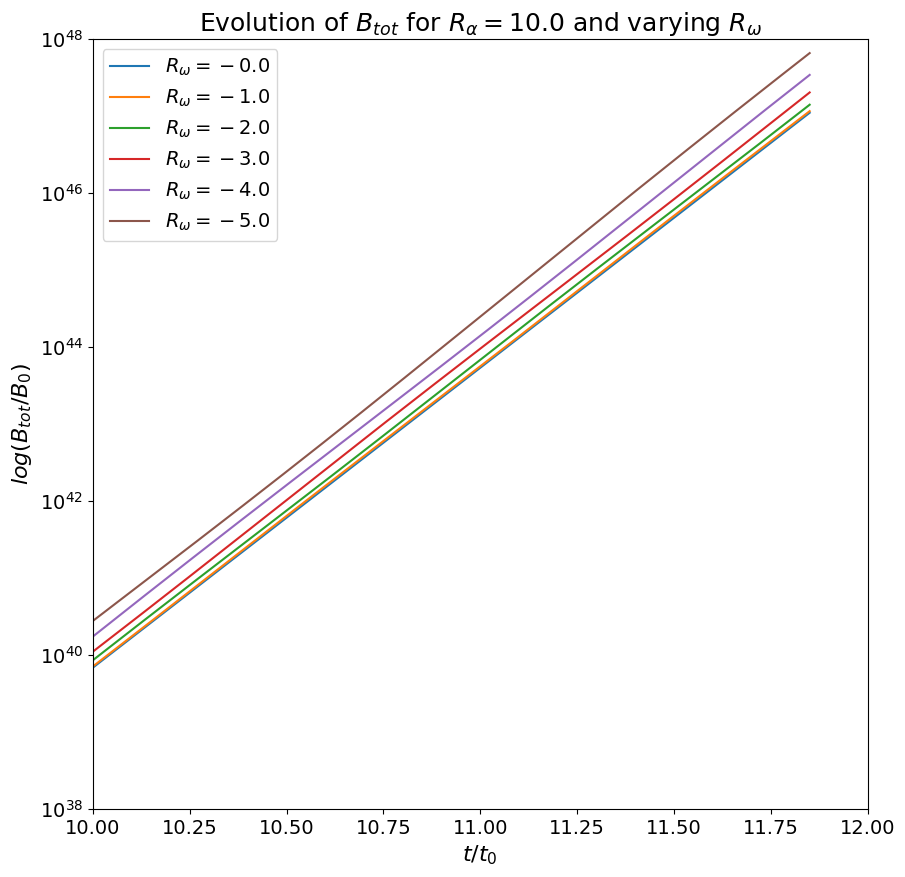

In [25]:
plt.figure(figsize=(10,10))

plt.plot(t, B1_total_11[:,len(z)//2], label = r'$R_\omega = -0.0$')
plt.plot(t, B1_total_12[:,len(z)//2], label = r'$R_\omega = -1.0$')
plt.plot(t, B1_total_13[:,len(z)//2], label = r'$R_\omega = -2.0$')
plt.plot(t, B1_total_14[:,len(z)//2], label = r'$R_\omega = -3.0$')
plt.plot(t, B1_total_15[:,len(z)//2], label = r'$R_\omega = -4.0$')
plt.plot(t, B1_total_16[:,len(z)//2], label = r'$R_\omega = -5.0$')

plt.legend(fontsize=14)
plt.yscale('log')
plt.xlim(10,12)
plt.ylim(1e38, 1e48)
plt.xlabel(r'$t/t_0$', fontsize = 16)
plt.ylabel(r'$log(B_{tot}/B_0)$', fontsize = 16)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.title(r'Evolution of $B_{tot}$ for $R_\alpha = 10.0$ and varying $R_\omega$', fontsize = 18)
plt.savefig('images/B_total_Ralpha_10.0.png')
plt.show()
plt.close()

In [28]:
B1_sols_11 = np.load('outputs_task3_2/B1_sol_dir_Romega_-0.0_Ralpha_5.0.npy', mmap_mode='r')
B1_sols_12 = np.load('outputs_task3_2/B1_sol_dir_Romega_-1.0_Ralpha_5.0.npy', mmap_mode='r')
B1_sols_13 = np.load('outputs_task3_2/B1_sol_dir_Romega_-2.0_Ralpha_5.0.npy', mmap_mode='r')
B1_sols_14 = np.load('outputs_task3_2/B1_sol_dir_Romega_-3.0_Ralpha_5.0.npy', mmap_mode='r')
B1_sols_15 = np.load('outputs_task3_2/B1_sol_dir_Romega_-4.0_Ralpha_5.0.npy', mmap_mode='r')
B1_sols_16 = np.load('outputs_task3_2/B1_sol_dir_Romega_-5.0_Ralpha_5.0.npy', mmap_mode='r')

B1_total_11 = np.sqrt((5**2)*B1_sols_11[0]**2 + B1_sols_11[1]**2)
B1_total_12 = np.sqrt((5**2)*B1_sols_12[0]**2 + B1_sols_12[1]**2)
B1_total_13 = np.sqrt((5**2)*B1_sols_13[0]**2 + B1_sols_13[1]**2)
B1_total_14 = np.sqrt((5**2)*B1_sols_14[0]**2 + B1_sols_14[1]**2)
B1_total_15 = np.sqrt((5**2)*B1_sols_15[0]**2 + B1_sols_15[1]**2)
B1_total_16 = np.sqrt((5**2)*B1_sols_16[0]**2 + B1_sols_16[1]**2)

In [30]:
plt.figure(figsize=(10,10))

plt.plot(t, B1_total_11[:,len(z)//2], label = r'$R_\omega = -0.0$')
plt.plot(t, B1_total_12[:,len(z)//2], label = r'$R_\omega = -1.0$')
plt.plot(t, B1_total_13[:,len(z)//2], label = r'$R_\omega = -2.0$')
plt.plot(t, B1_total_14[:,len(z)//2], label = r'$R_\omega = -3.0$')
plt.plot(t, B1_total_15[:,len(z)//2], label = r'$R_\omega = -4.0$')
plt.plot(t, B1_total_16[:,len(z)//2], label = r'$R_\omega = -5.0$')

plt.legend(fontsize=14)
plt.yscale('log')
# plt.xlim(10,12)
# plt.ylim(1e38, 1e48)
plt.xlabel(r'$t/t_0$', fontsize = 16)
plt.ylabel(r'$log(B_{tot}/B_0)$', fontsize = 16)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.title(r'Evolution of $B_{tot}$ for $R_\alpha = 5.0$ and varying $R_\omega$', fontsize = 18)
plt.savefig('images/B_total_Ralpha_5.0.png')
plt.close()

In [31]:
B1_sols_11 = np.load('outputs_task3_2/B1_sol_dir_Romega_-17.5_Ralpha_9.0.npy', mmap_mode='r')
B1_sols_12 = np.load('outputs_task3_2/B1_sol_dir_Romega_-17.5_Ralpha_10.0.npy', mmap_mode='r')
B1_sols_13 = np.load('outputs_task3_2/B1_sol_dir_Romega_-17.5_Ralpha_11.0.npy', mmap_mode='r')
B1_sols_14 = np.load('outputs_task3_2/B1_sol_dir_Romega_-17.5_Ralpha_12.0.npy', mmap_mode='r')
B1_sols_15 = np.load('outputs_task3_2/B1_sol_dir_Romega_-17.5_Ralpha_13.0.npy', mmap_mode='r')
B1_sols_16 = np.load('outputs_task3_2/B1_sol_dir_Romega_-17.5_Ralpha_14.0.npy', mmap_mode='r')

B1_total_11 = np.sqrt((9**2)*B1_sols_11[0]**2 + B1_sols_11[1]**2)
B1_total_12 = np.sqrt((10**2)*B1_sols_12[0]**2 + B1_sols_12[1]**2)
B1_total_13 = np.sqrt((11**2)*B1_sols_13[0]**2 + B1_sols_13[1]**2)
B1_total_14 = np.sqrt((12**2)*B1_sols_14[0]**2 + B1_sols_14[1]**2)
B1_total_15 = np.sqrt((13**2)*B1_sols_15[0]**2 + B1_sols_15[1]**2)
B1_total_16 = np.sqrt((14**2)*B1_sols_16[0]**2 + B1_sols_16[1]**2)

In [32]:
plt.figure(figsize=(10,10))

plt.plot(t, B1_total_11[:,len(z)//2], label = r'$R_\alpha = 9.0$')
plt.plot(t, B1_total_12[:,len(z)//2], label = r'$R_\alpha = 10.0$')
plt.plot(t, B1_total_13[:,len(z)//2], label = r'$R_\alpha = 11.0$')
plt.plot(t, B1_total_14[:,len(z)//2], label = r'$R_\alpha = 12.0$')
plt.plot(t, B1_total_15[:,len(z)//2], label = r'$R_\alpha = 13.0$')
plt.plot(t, B1_total_16[:,len(z)//2], label = r'$R_\alpha = 14.0$')

plt.legend(fontsize=14)
plt.yscale('log')
# plt.xlim(10,12)
# plt.ylim(1e38, 1e48)
plt.xlabel(r'$t/t_0$', fontsize = 16)
plt.ylabel(r'$log(B_{tot}/B_0)$', fontsize = 16)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.title(r'Evolution of $B_{tot}$ for $R_\omega = -17.5$ and varying $R_\alpha$', fontsize = 18)
plt.savefig('images/B_total_Romega_-17.5.png')
plt.close()

In [37]:
B1_sols_1 = np.load('outputs_task3_2/B1_sol_dir_Romega_-3.5_Ralpha_14.0.npy', mmap_mode='r')
B1_sols_2 = np.load('outputs_task3_2/B1_sol_dir_Romega_-3.5_Ralpha_14.5.npy', mmap_mode='r')
B1_sols_3 = np.load('outputs_task3_2/B1_sol_dir_Romega_-4.0_Ralpha_14.0.npy', mmap_mode='r')
B1_sols_4 = np.load('outputs_task3_2/B1_sol_dir_Romega_-4.0_Ralpha_14.5.npy', mmap_mode='r')
B1_sols_5 = np.load('outputs_task3_2/B1_sol_dir_Romega_-4.0_Ralpha_13.5.npy', mmap_mode='r')
B1_sols_6 = np.load('outputs_task3_2/B1_sol_dir_Romega_-4.5_Ralpha_13.0.npy', mmap_mode='r')
B1_sols_7 = np.load('outputs_task3_2/B1_sol_dir_Romega_-4.5_Ralpha_13.5.npy', mmap_mode='r')
B1_sols_8 = np.load('outputs_task3_2/B1_sol_dir_Romega_-4.5_Ralpha_14.0.npy', mmap_mode='r')
B1_sols_9 = np.load('outputs_task3_2/B1_sol_dir_Romega_-5.0_Ralpha_12.5.npy', mmap_mode='r')
B1_sols_10 = np.load('outputs_task3_2/B1_sol_dir_Romega_-5.0_Ralpha_13.0.npy', mmap_mode='r')
B1_sols_11 = np.load('outputs_task3_2/B1_sol_dir_Romega_-5.0_Ralpha_13.5.npy', mmap_mode='r')
B1_sols_12 = np.load('outputs_task3_2/B1_sol_dir_Romega_-5.5_Ralpha_12.0.npy', mmap_mode='r')
B1_sols_13 = np.load('outputs_task3_2/B1_sol_dir_Romega_-5.5_Ralpha_12.5.npy', mmap_mode='r')
B1_sols_14 = np.load('outputs_task3_2/B1_sol_dir_Romega_-5.5_Ralpha_13.0.npy', mmap_mode='r')
B1_sols_15 = np.load('outputs_task3_2/B1_sol_dir_Romega_-6.0_Ralpha_12.0.npy', mmap_mode='r')
B1_sols_16 = np.load('outputs_task3_2/B1_sol_dir_Romega_-6.5_Ralpha_11.0.npy', mmap_mode='r')
B1_sols_17 = np.load('outputs_task3_2/B1_sol_dir_Romega_-6.5_Ralpha_11.5.npy', mmap_mode='r')
B1_sols_18 = np.load('outputs_task3_2/B1_sol_dir_Romega_-6.5_Ralpha_12.0.npy', mmap_mode='r')
B1_sols_19 = np.load('outputs_task3_2/B1_sol_dir_Romega_-7.0_Ralpha_11.0.npy', mmap_mode='r')
B1_sols_20 = np.load('outputs_task3_2/B1_sol_dir_Romega_-7.0_Ralpha_11.5.npy', mmap_mode='r')

B1_total_1 = np.sqrt((14.0**2)*B1_sols_1[0]**2 + B1_sols_1[1]**2)
B1_total_2 = np.sqrt((14.5**2)*B1_sols_2[0]**2 + B1_sols_2[1]**2)
B1_total_3 = np.sqrt((14.0**2)*B1_sols_3[0]**2 + B1_sols_3[1]**2)
B1_total_4 = np.sqrt((14.5**2)*B1_sols_4[0]**2 + B1_sols_4[1]**2)
B1_total_5 = np.sqrt((13.5**2)*B1_sols_5[0]**2 + B1_sols_5[1]**2)
B1_total_6 = np.sqrt((13.0**2)*B1_sols_6[0]**2 + B1_sols_6[1]**2)
B1_total_7 = np.sqrt((13.5**2)*B1_sols_7[0]**2 + B1_sols_7[1]**2)
B1_total_8 = np.sqrt((14.0**2)*B1_sols_8[0]**2 + B1_sols_8[1]**2)
B1_total_9 = np.sqrt((12.5**2)*B1_sols_9[0]**2 + B1_sols_9[1]**2)
B1_total_10 = np.sqrt((13.0**2)*B1_sols_10[0]**2 + B1_sols_10[1]**2)
B1_total_11 = np.sqrt((13.5**2)*B1_sols_11[0]**2 + B1_sols_11[1]**2)
B1_total_12 = np.sqrt((12.0**2)*B1_sols_12[0]**2 + B1_sols_12[1]**2)
B1_total_13 = np.sqrt((12.5**2)*B1_sols_13[0]**2 + B1_sols_13[1]**2)
B1_total_14 = np.sqrt((13.0**2)*B1_sols_14[0]**2 + B1_sols_14[1]**2)
B1_total_15 = np.sqrt((12.0**2)*B1_sols_15[0]**2 + B1_sols_15[1]**2)
B1_total_16 = np.sqrt((11.0**2)*B1_sols_16[0]**2 + B1_sols_16[1]**2)
B1_total_17 = np.sqrt((11.5**2)*B1_sols_17[0]**2 + B1_sols_17[1]**2)
B1_total_18 = np.sqrt((12.0**2)*B1_sols_18[0]**2 + B1_sols_18[1]**2)
B1_total_19 = np.sqrt((11.0**2)*B1_sols_19[0]**2 + B1_sols_19[1]**2)
B1_total_20 = np.sqrt((11.5**2)*B1_sols_20[0]**2 + B1_sols_20[1]**2)

In [38]:
plt.figure(figsize=(10,10))

plt.plot(t, B1_total_1[:, len(z)//2], label = r'$R_\omega = -3.5, R_\alpha = 14.0$', color = 'red')
plt.plot(t, B1_total_2[:, len(z)//2], label = r'$R_\omega = -3.5, R_\alpha = 14.5$', color = 'red', linestyle = '--')
plt.plot(t, B1_total_3[:, len(z)//2], label = r'$R_\omega = -4.0, R_\alpha = 14.0$', color = 'green')
plt.plot(t, B1_total_4[:, len(z)//2], label = r'$R_\omega = -4.0, R_\alpha = 14.5$', color = 'green', linestyle = '--')
plt.plot(t, B1_total_5[:, len(z)//2], label = r'$R_\omega = -4.0, R_\alpha = 13.5$', color = 'green', linestyle = '-.')
plt.plot(t, B1_total_6[:, len(z)//2], label = r'$R_\omega = -4.5, R_\alpha = 13.0$', color = 'cyan')
plt.plot(t, B1_total_7[:, len(z)//2], label = r'$R_\omega = -4.5, R_\alpha = 13.5$', color = 'cyan', linestyle = '--')
plt.plot(t, B1_total_8[:, len(z)//2], label = r'$R_\omega = -4.5, R_\alpha = 14.0$', color = 'cyan', linestyle = '-.')
plt.plot(t, B1_total_9[:, len(z)//2], label = r'$R_\omega = -5.0, R_\alpha = 12.5$', color = 'grey')
plt.plot(t, B1_total_10[:, len(z)//2], label = r'$R_\omega = -5.0, R_\alpha = 13.0$', color = 'grey', linestyle = '--')
plt.plot(t, B1_total_11[:, len(z)//2], label = r'$R_\omega = -5.0, R_\alpha = 13.5$', color = 'grey', linestyle = '-.')
plt.plot(t, B1_total_12[:, len(z)//2], label = r'$R_\omega = -5.5, R_\alpha = 12.0$', color = 'lime')
plt.plot(t, B1_total_13[:, len(z)//2], label = r'$R_\omega = -5.5, R_\alpha = 12.5$', color = 'lime', linestyle = '--')
plt.plot(t, B1_total_14[:, len(z)//2], label = r'$R_\omega = -5.5, R_\alpha = 13.0$', color = 'lime', linestyle = '-.')
plt.plot(t, B1_total_15[:, len(z)//2], label = r'$R_\omega = -6.0, R_\alpha = 12.0$', color = 'skyblue')
plt.plot(t, B1_total_16[:, len(z)//2], label = r'$R_\omega = -6.5, R_\alpha = 11.0$', color = 'violet')
plt.plot(t, B1_total_17[:, len(z)//2], label = r'$R_\omega = -6.5, R_\alpha = 11.5$', color = 'violet', linestyle = '--')
plt.plot(t, B1_total_18[:, len(z)//2], label = r'$R_\omega = -6.5, R_\alpha = 12.0$', color = 'violet', linestyle = '-.')
plt.plot(t, B1_total_19[:, len(z)//2], label = r'$R_\omega = -7.0, R_\alpha = 11.0$', color = 'seagreen')
plt.plot(t, B1_total_20[:, len(z)//2], label = r'$R_\omega = -7.0, R_\alpha = 11.5$', color = 'seagreen', linestyle = '--')

plt.xlabel(r'$t/t_0$', fontsize = 16)
plt.ylabel(r'$log(B_{tot}/B_0)$', fontsize = 16)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.title(r'Evolution of $B_{tot}$ for different $R_\omega$ and $R_\alpha$', fontsize = 18)
plt.legend(fontsize = 14, bbox_to_anchor=(1.01, 1.01))
plt.yscale('log')
plt.savefig('images/B_tot_evolution_Romega_Ralpha_transition.png', bbox_inches='tight')
plt.close()

Ralpha2 = np.linspace(14.5, 20, 12)
Romega2 = np.linspace(0, 19.5, 40)
B1_sols = np.empty((20, 12, 2, 15001, 50))
B1_total = np.empty((20, 12, 15001, 50))
for i in range(20):
    for j in range(len(Ralpha2)):
        B1_sols[i][j] = np.load('outputs_task3_2/B1_sol_dir_Romega_'+str(Romega[i])+'_Ralpha_'+str(Ralpha[j])+'.npy', mmap_mode='r')
        B1_total[i][j] = np.sqrt((Ralpha[j]**2)*B1_sols[i,j,0,:,:]**2 + B1_sols[i,j,1,:,:]**2)
    

plt.figure(figsize=(10,10))
for i in range(20):
    for j in range(12):
        plt.plot(t, B1_total[i,j,:,len(z)//2], label = r'$R_\omega = $'+str(Romega[i])+r'$, R_\alpha = $'+str(Ralpha2[j]))
plt.yscale('log')
# plt.legend()
plt.show()
plt.close()